## We have divided the problem into two parts
(a) Predict the floor number
(b) Predict the way points or location on that floor

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
pd.options.mode.chained_assignment = None  # default='warn'
from dataclasses import dataclass
from sklearn import preprocessing

In [ ]:
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Function to connect waypoint coordinates with straight lines
#This will be used for second part of project.We will discuss about this later.
def connect_waypoints(wp_df):
  if(wp_df.at[0,'waypoint_val1']==''):
    wp_df.at[0,'waypoint_val1']=0
  if(wp_df.at[0,'waypoint_val2']==''):
    wp_df.at[0,'waypoint_val2']=0  
  j=0
  i=0
  last=0
  #print(wp_df.head(5))
  while i < (len(wp_df)-1):
    j=i+1
    while((wp_df.at[j,'waypoint_val1']==0) and (wp_df.at[j,'waypoint_val2']==0) ):
      if(j==len(wp_df)-1):
        wp_df.at[j,'waypoint_val1']=wp_df.at[i,'waypoint_val1']
        wp_df.at[j,'waypoint_val2']=wp_df.at[i,'waypoint_val2']
        last=1
        break
      j+=1
    temp_arrayx=np.linspace(wp_df.at[i,'waypoint_val1'],wp_df.at[j,'waypoint_val1'], num=j-i+1)
    temp_arrayy=np.linspace(wp_df.at[i,'waypoint_val2'],wp_df.at[j,'waypoint_val2'], num=j-i+1)
    #print(temp_arrayx)
    m=0
    for k in range(i,j+1):
      wp_df.at[k,'waypoint_val1']=temp_arrayx[m]
      wp_df.at[k,'waypoint_val2']=temp_arrayy[m]
      #For final comparison of our predicted location, we will need to mark which waypoints were in original data before connecting them
      #print('k=',k,'i=',i,'j=',j)
      if((k==i) and (last==0)):
        wp_df.at[k,'interpolated']=1 #original waypoints
      else:
        wp_df.at[k,'interpolated']=0  #interpolated waypoints
      m+=1
    i=j
  return wp_df     


In [ ]:
# Function to extract arrays for each sensor with timeslots.
# This particular function is modified from the function provided by the competition's github page at https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []
    line_count=0
    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        #line_count=line_count+1
        #if(line_count>3000):
        #  break
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = int(line_data[0])
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = int(line_data[0])
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce,dtype=np.float)
    acce_uncali = np.array(acce_uncali,dtype=np.float)
    gyro = np.array(gyro,dtype=np.float)
    gyro_uncali = np.array(gyro_uncali,dtype=np.float)
    magn = np.array(magn,dtype=np.float)
    magn_uncali = np.array(magn_uncali,dtype=np.float)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [ ]:
#Function to go through all the files in the folder and return the sensor data 
# in the form of arrays
@dataclass
class trace:
    sequence: np.ndarray
    target_seq: np.ndarray
    waypoint_seq: np.ndarray
    wp_full_seq: np.ndarray

def convert_to_df(file_path,floor,timeslots):
    pathlist = Path(file_path).rglob('*.txt')
    sequence = list()
    target_seq=list()
    waypoint_seq=list()
    wp_full_seq=list()
    path_id=1
    floor_trace_df=pd.DataFrame()
    for path in pathlist:
         # because path is object not string
        path_in_str = str(path)
         # print(path_in_str)
        trace_file = read_data_file(path_in_str)
        trace_df=pd.DataFrame()
        if(trace_file.acce.size):
            acce_df=pd.DataFrame(trace_file.acce, columns=['Timestamp','acce_val1','acce_val2','acce_val3'])
        if(trace_file.acce_uncali.size):
            acce__uncal_df=pd.DataFrame(trace_file.acce_uncali, columns=['Timestamp','acce_uncal_val1','acce_uncal_val2','acce_uncal_val3'])   
        if(trace_file.gyro.size):
            gyro_df=pd.DataFrame(trace_file.gyro, columns=['Timestamp','gyro_val1','gyro_val2','gyro_val3'])
        if(trace_file.gyro_uncali.size):
            gyro_uncal_df=pd.DataFrame(trace_file.gyro_uncali, columns=['Timestamp','gyro_uncal_val1','gyro_uncal_val2','gyro_uncal_val3'])
        if(trace_file.magn.size):
            magn_df=pd.DataFrame(trace_file.magn, columns=['Timestamp','magn_val1','magn_val2','magn_val3'])
        if(trace_file.magn_uncali.size):
            magn_uncal_df=pd.DataFrame(trace_file.magn_uncali, columns=['Timestamp','magn_uncal_val1','magn_uncal_val2','magn_uncal_val3'])
        if(trace_file.ahrs.size):
            rot_df=pd.DataFrame(trace_file.ahrs, columns=['Timestamp','rot_val1','rot_val2','rot_val3'])           
        if(trace_file.wifi.size):
            wifi_df=pd.DataFrame(trace_file.wifi, columns=['Timestamp','wifi_val1','wifi_val2','wifi_val3','wifi_val4']) 
        if(trace_file.ibeacon.size):
            ibeacon_df=pd.DataFrame(trace_file.ibeacon, columns=['Timestamp','ibeacon_val1','ibeacon_val2'])    
        if(trace_file.waypoint.size):
            waypoint_df=pd.DataFrame(trace_file.waypoint, columns=['Timestamp','waypoint_val1','waypoint_val2'])
        
        #change data type of wifi dataframe timestamp and ibeacon timestamp
        wifi_df["Timestamp"] = wifi_df.Timestamp.astype(float)
        ibeacon_df["Timestamp"] = ibeacon_df.Timestamp.astype(float)
        trace_df = pd.merge(acce_df, acce__uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, rot_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, wifi_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, ibeacon_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, waypoint_df, on='Timestamp', how='outer')
        ###### Cast time stamp to integer
        trace_df["Timestamp"] = trace_df.Timestamp.astype(int)

        # sorting by Timestamp and deleting duplicate timeslots 
        
        trace_df.sort_values("Timestamp", inplace = True)
        trace_df = trace_df.reset_index(drop=True)
        trace_df.drop_duplicates(subset="Timestamp",keep=False, inplace=True)
        trace_df = trace_df.reset_index(drop=True)
        
        trace_df=trace_df.replace(np.nan,0)

        #keep only top 200 rows in one sequence     
        #trace_df=trace_df.head(200)

        #for i in range(0,len(trace_df)):
         # trace_df.at[i,'Timestamp']=i
        
        #trace_df['time_index'] = trace_df.index
        #print(trace_df.head())
        #trace_df['floor_name']=floor
        #trace_df['path_id']=floor+path_id
        #path_id=path_id+1
        #trace_df['wifi_df'].fillna(0)
        #trace_df['ibeacon_df'].fillna(0)
        #trace_df['wifi_df'].fillna(0)
        

        wp_df = trace_df[['waypoint_val1', 'waypoint_val2']].copy()
        wp_df=connect_waypoints(wp_df)
        wp_values=wp_df.values
        #Removing text based fields in dataframe
        trace_df=trace_df.drop(['Timestamp'], axis=1)
        trace_df=trace_df.drop(['wifi_val1'], axis=1)
        trace_df=trace_df.drop(['wifi_val2'], axis=1)
        trace_df=trace_df.drop(['ibeacon_val1'], axis=1)
        trace_df.astype('float32')        
        trace_df=trace_df.drop(['waypoint_val1','waypoint_val2'], axis=1)
        #floor_trace_df=floor_trace_df.append(trace_df)
        values = trace_df.values 


        


        #Now split sequence into required number of timeslots
        l=int(len(values)/timeslots)
        k=0
        for m in range(l):
          s_temp=values[k:k+timeslots]
          wp_temp=wp_values[k:k+timeslots]
          #Normalize
          #min_max_scaler = preprocessing.MinMaxScaler()
          #s_scaled = min_max_scaler.fit_transform(s_temp)
          sequence.append(s_temp)
          wp_full_seq.append(wp_temp)
          target_seq.append(floor)
          wp_temp=wp_df.iloc[k:k+timeslots,0:]
          wp_temp=wp_temp.reset_index(drop=True)
          #wp_temp=connect_waypoints(wp_temp)
        #Now after connecting the waypoints, the avearge has become a wieghted average in time series
          wp_avg_x=wp_temp['waypoint_val1'].mean()
          wp_avg_y=wp_temp['waypoint_val2'].mean()
        #maximum and minimum will be useful in second part
          wp_max_x=wp_temp['waypoint_val1'].max()
          wp_min_x=wp_temp['waypoint_val1'].min()
          wp_max_y=wp_temp['waypoint_val2'].max()
          wp_min_y=wp_temp['waypoint_val2'].min()
          
          waypoint_seq.append([wp_avg_x,wp_avg_y,wp_max_x,wp_min_x,wp_max_y,wp_min_y])
          k+=timeslots

    return trace(sequence,target_seq,waypoint_seq,wp_full_seq)

In [ ]:
#Extracting data for B1 floor only
sequences = list()
target_sequence=list()
waypoint_sequence=list()
waypoint_full_sequence=list()
#floors_df=pd.DataFrame()
file_path = '/content/drive/MyDrive/building1/data/B1'
trace_values=(convert_to_df(file_path,0,5))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
waypoint_full_sequence.extend(trace_values.wp_full_seq)

In [ ]:
print('Number of sequences',len(sequences))
print('Number of targets',len(target_sequence))
print('Number of timeslots in first sequence',(sequences[0].shape)[0])
print('Number of timeslots in tenth sequence',(sequences[9].shape)[0])
print('Number of timeslots in hundredth sequence',(sequences[99].shape)[0])

Number of sequences 44943
Number of targets 44943
Number of timeslots in first sequence 5
Number of timeslots in tenth sequence 5
Number of timeslots in hundredth sequence 5


# Part 2 

### After knowing the floor, now we need to predict waypoints on that floor.

### We assume that floor B1 was predicted in first part. So, for this part we will only take data of floor B1.

In [ ]:
len(waypoint_sequence)

44943

In [ ]:
len(sequences)

44943

In [ ]:
##We will divide the area into grids. But first we need to know the dimensions to work with
wp_df = pd.DataFrame(waypoint_sequence, columns = ['avg_x','avg_y','max_x','min_x','max_y','min_y',])
wp_df=wp_df.head(len(sequences))  #number of sequences for floor B1
wp_df = wp_df.round(decimals=5)
floor_max_x=wp_df['max_x'].max()
floor_min_x=wp_df['min_x'].min()
floor_max_y=wp_df['max_y'].max()
floor_min_y=wp_df['min_y'].min()
print(floor_max_x,floor_min_x,floor_max_y,floor_min_y)

233.94418 36.63454 192.99721 75.00506


In [ ]:
#Creating grid for labelling
#We will create a 10X10 grid for 100 labels
array_x=np.linspace(floor_min_x,floor_max_x,11)
array_y=np.linspace(floor_min_y,floor_max_y,11)
label=list()
k=0
for j in range(1,11):
  for i in range(1,11):
    label.append([array_x[i],array_y[j],k])
    k+=1  

In [ ]:
#Now we need to give labels to our waypoints sequence on the basis of average waypoints
print(wp_df.head())
for i in range(len(wp_df)):
  for j in range(len(label)):
    if(wp_df.at[i,'avg_x']<=label[j][0]):
       for p in range(len(label)):
         if(wp_df.at[i,'avg_y']<=label[p][1]):
           wp_df.at[i,'label']=label[j+p][2]
           break
       break    
print(wp_df.head(20))           

       avg_x      avg_y      max_x      min_x      max_y      min_y
0  198.39353  163.51489  198.41872  198.36833  163.52063  163.50914
1  198.45652  163.50052  198.48171  198.43132  163.50627  163.49478
2  198.51951  163.48616  198.54471  198.49431  163.49191  163.48042
3  198.58250  163.47180  198.60770  198.55730  163.47755  163.46606
4  198.64549  163.45744  198.67069  198.62030  163.46318  163.45170
        avg_x      avg_y      max_x      min_x      max_y      min_y  label
0   198.39353  163.51489  198.41872  198.36833  163.52063  163.50914   78.0
1   198.45652  163.50052  198.48171  198.43132  163.50627  163.49478   78.0
2   198.51951  163.48616  198.54471  198.49431  163.49191  163.48042   78.0
3   198.58250  163.47180  198.60770  198.55730  163.47755  163.46606   78.0
4   198.64549  163.45744  198.67069  198.62030  163.46318  163.45170   78.0
5   198.70848  163.44308  198.73368  198.68329  163.44882  163.43733   78.0
6   198.77148  163.42872  198.79667  198.74628  163.43446  1

In [ ]:
#Now we need to create new train, validation and test split for only building 1
train_length=int(len(sequences)*0.7)
val_length=int(len(sequences)*0.15)
test_length=len(sequences)-train_length-val_length

train_flags=np.full((train_length), 0)
validation_flags=np.full((val_length), 1)
test_flags=np.full((test_length), 2)

flags=[]
flags.extend(train_flags)
flags.extend(validation_flags)
flags.extend(test_flags)
np.random.shuffle(flags)
len(flags)

44943

In [ ]:
#Creating target sequence
target_sequence2=wp_df['label'].values
#Slice the sequence to get only floor B1 data
sequences2=sequences[0:len(sequences)]
target_sequence2=np.array(target_sequence2)
target_sequence2

array([78., 78., 78., ..., 73., 73., 73.])

In [ ]:
train = [sequences2[i] for i in range(len(flags)) if (flags[i]==0)]
validation = [sequences2[i] for i in range(len(flags)) if flags[i]==1]
test = [sequences2[i] for i in range(len(flags)) if flags[i]==2]
test_seq_wp=[waypoint_full_sequence[i] for i in range(len(flags)) if flags[i]==2]

train_target = [target_sequence2[i] for i in range(len(flags)) if (flags[i]==0)]
validation_target = [target_sequence2[i] for i in range(len(flags)) if flags[i]==1]
test_target = [target_sequence2[i] for i in range(len(flags)) if flags[i]==2]
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

train_target = np.array(train_target)
train_target=to_categorical(train_target,num_classes = 100)

validation_target = np.array(validation_target)
validation_target=to_categorical(validation_target,num_classes = 100)
test_target = np.array(test_target)
test_target=to_categorical(test_target,num_classes = 100)

In [ ]:
print(sequences2[0].shape)
train_target[0]
len(test_seq_wp)

(5, 24)


6742

In [ ]:
train=tf.convert_to_tensor(train, np.float32)
train_target=tf.convert_to_tensor(train_target, np.float32)
validation=tf.convert_to_tensor(validation, np.float32)
validation_target=tf.convert_to_tensor(validation_target, np.float32)
test=tf.convert_to_tensor(test, np.float32)
test_target=tf.convert_to_tensor(test_target, np.float32)

In [ ]:
#Trial with 100 grid cells 
from keras.layers import Dropout
seq_len = 5
seq_bredth=24
model = Sequential()
model.add(Bidirectional(LSTM(256,return_sequences=True),input_shape=(seq_len, seq_bredth),merge_mode='concat'))
model.add(Dropout(0.2))
model.add(LSTM(256, input_shape=(3, 512)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 512)            575488    
_________________________________________________________________
dropout (Dropout)            (None, 5, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1

In [ ]:
#This is 100 cells simple LSTM
adam = Adam(lr=0.001)
checkpoint_filepath = '/content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl'
chk = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))

Epoch 1/200
246/246 [==============================] - 48s 174ms/step - loss: 3.6314 - accuracy: 0.0999 - val_loss: 2.5799 - val_accuracy: 0.2483

Epoch 00001: val_accuracy improved from -inf to 0.24833, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 2/200
246/246 [==============================] - 42s 169ms/step - loss: 2.4043 - accuracy: 0.2692 - val_loss: 1.8128 - val_accuracy: 0.4047

Epoch 00002: val_accuracy improved from 0.24833 to 0.40469, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 3/200
246/246 [==============================] - 42s 171ms/step - loss: 1.8988 - accuracy: 0.3727 - val_loss: 1.6011 - val_accuracy: 0.4415

Epoch 00003: val_accuracy improved from 0.40469 to 0.44148, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 4/200
246/246 [==============================] - 42s 172ms/step - loss: 1.6934 - accuracy: 0.4296 - val_loss: 1.4623 - val_accuracy: 0.4882

Epoch 00004: val_accuracy improved from 0.44148 to 0.48821, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 5/200
246/246 [==============================] - 42s 171ms/step - loss: 1.5420 - accuracy: 0.4645 - val_loss: 1.3325 - val_accuracy: 0.5305

Epoch 00005: val_accuracy improved from 0.48821 to 0.53049, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 6/200
246/246 [==============================] - 43s 173ms/step - loss: 1.4479 - accuracy: 0.4899 - val_loss: 1.2412 - val_accuracy: 0.5567

Epoch 00006: val_accuracy improved from 0.53049 to 0.55674, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 7/200
246/246 [==============================] - 42s 171ms/step - loss: 1.3903 - accuracy: 0.5080 - val_loss: 1.2222 - val_accuracy: 0.5676

Epoch 00007: val_accuracy improved from 0.55674 to 0.56757, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 8/200
246/246 [==============================] - 43s 174ms/step - loss: 1.2813 - accuracy: 0.5425 - val_loss: 1.2254 - val_accuracy: 0.5593

Epoch 00008: val_accuracy did not improve from 0.56757
Epoch 9/200
246/246 [==============================] - 42s 173ms/step - loss: 1.2378 - accuracy: 0.5571 - val_loss: 1.1060 - val_accuracy: 0.5944

Epoch 00009: val_accuracy improved from 0.56757 to 0.59442, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 10/200
246/246 [==============================] - 42s 172ms/step - loss: 1.1887 - accuracy: 0.5734 - val_loss: 1.1410 - val_accuracy: 0.5852

Epoch 00010: val_accuracy did not improve from 0.59442
Epoch 11/200
246/246 [==============================] - 42s 172ms/step - loss: 1.1284 - accuracy: 0.5944 - val_loss: 1.0569 - val_accuracy: 0.6146

Epoch 00011: val_accuracy improved from 0.59442 to 0.61460, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 12/200
246/246 [==============================] - 42s 170ms/step - loss: 1.1065 - accuracy: 0.6026 - val_loss: 1.1280 - val_accuracy: 0.5935

Epoch 00012: val_accuracy did not improve from 0.61460
Epoch 13/200
246/246 [==============================] - 42s 169ms/step - loss: 1.0860 - accuracy: 0.6095 - val_loss: 0.9939 - val_accuracy: 0.6325

Epoch 00013: val_accuracy improved from 0.61460 to 0.63255, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 14/200
246/246 [==============================] - 42s 170ms/step - loss: 1.0170 - accuracy: 0.6316 - val_loss: 1.0107 - val_accuracy: 0.6309

Epoch 00014: val_accuracy did not improve from 0.63255
Epoch 15/200
246/246 [==============================] - 42s 171ms/step - loss: 1.0117 - accuracy: 0.6312 - val_loss: 1.0089 - val_accuracy: 0.6342

Epoch 00015: val_accuracy improved from 0.63255 to 0.63418, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 16/200
246/246 [==============================] - 42s 172ms/step - loss: 1.0750 - accuracy: 0.6185 - val_loss: 0.9586 - val_accuracy: 0.6547

Epoch 00016: val_accuracy improved from 0.63418 to 0.65465, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 17/200
246/246 [==============================] - 42s 172ms/step - loss: 0.9670 - accuracy: 0.6500 - val_loss: 0.9131 - val_accuracy: 0.6643

Epoch 00017: val_accuracy improved from 0.65465 to 0.66429, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 18/200
246/246 [==============================] - 42s 171ms/step - loss: 0.9260 - accuracy: 0.6635 - val_loss: 0.9209 - val_accuracy: 0.6653

Epoch 00018: val_accuracy improved from 0.66429 to 0.66533, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 19/200
246/246 [==============================] - 42s 172ms/step - loss: 0.8959 - accuracy: 0.6696 - val_loss: 0.9197 - val_accuracy: 0.6630

Epoch 00019: val_accuracy did not improve from 0.66533
Epoch 20/200
246/246 [==============================] - 42s 171ms/step - loss: 0.9040 - accuracy: 0.6731 - val_loss: 0.8979 - val_accuracy: 0.6701

Epoch 00020: val_accuracy improved from 0.66533 to 0.67008, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 21/200
246/246 [==============================] - 42s 172ms/step - loss: 0.8877 - accuracy: 0.6828 - val_loss: 0.9134 - val_accuracy: 0.6781

Epoch 00021: val_accuracy improved from 0.67008 to 0.67809, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 22/200
246/246 [==============================] - 42s 172ms/step - loss: 0.8427 - accuracy: 0.6942 - val_loss: 0.8546 - val_accuracy: 0.6953

Epoch 00022: val_accuracy improved from 0.67809 to 0.69530, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 23/200
246/246 [==============================] - 42s 171ms/step - loss: 0.8256 - accuracy: 0.6995 - val_loss: 0.9334 - val_accuracy: 0.6713

Epoch 00023: val_accuracy did not improve from 0.69530
Epoch 24/200
246/246 [==============================] - 42s 171ms/step - loss: 0.8115 - accuracy: 0.7029 - val_loss: 0.8183 - val_accuracy: 0.7061

Epoch 00024: val_accuracy improved from 0.69530 to 0.70613, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 25/200
246/246 [==============================] - 43s 174ms/step - loss: 0.7881 - accuracy: 0.7080 - val_loss: 0.8339 - val_accuracy: 0.6971

Epoch 00025: val_accuracy did not improve from 0.70613
Epoch 26/200
246/246 [==============================] - 42s 172ms/step - loss: 0.7641 - accuracy: 0.7191 - val_loss: 0.8131 - val_accuracy: 0.7029

Epoch 00026: val_accuracy did not improve from 0.70613
Epoch 27/200
246/246 [==============================] - 42s 172ms/step - loss: 0.7280 - accuracy: 0.7291 - val_loss: 0.7758 - val_accuracy: 0.7204

Epoch 00027: val_accuracy improved from 0.70613 to 0.72037, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 28/200
246/246 [==============================] - 42s 172ms/step - loss: 0.7187 - accuracy: 0.7351 - val_loss: 0.8476 - val_accuracy: 0.6914

Epoch 00028: val_accuracy did not improve from 0.72037
Epoch 29/200
246/246 [==============================] - 42s 170ms/step - loss: 0.7123 - accuracy: 0.7374 - val_loss: 0.8084 - val_accuracy: 0.7073

Epoch 00029: val_accuracy did not improve from 0.72037
Epoch 30/200
246/246 [==============================] - 42s 171ms/step - loss: 0.7390 - accuracy: 0.7329 - val_loss: 0.7971 - val_accuracy: 0.7168

Epoch 00030: val_accuracy did not improve from 0.72037
Epoch 31/200
246/246 [==============================] - 42s 172ms/step - loss: 0.6895 - accuracy: 0.7457 - val_loss: 0.8341 - val_accuracy: 0.7049

Epoch 00031: val_accuracy did not improve from 0.72037
Epoch 32/200
246/246 [==============================] - 42s 171ms/step - loss: 0.6576 - accuracy: 0.7567 - val_loss: 0.8389 - val_accuracy: 0.6972

Epoch 00032: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 34/200
246/246 [==============================] - 42s 171ms/step - loss: 0.6269 - accuracy: 0.7700 - val_loss: 0.7972 - val_accuracy: 0.7211

Epoch 00034: val_accuracy did not improve from 0.72556
Epoch 35/200
246/246 [==============================] - 42s 170ms/step - loss: 0.6544 - accuracy: 0.7630 - val_loss: 0.7472 - val_accuracy: 0.7221

Epoch 00035: val_accuracy did not improve from 0.72556
Epoch 36/200
246/246 [==============================] - 42s 170ms/step - loss: 0.5842 - accuracy: 0.7809 - val_loss: 0.7621 - val_accuracy: 0.7300

Epoch 00036: val_accuracy improved from 0.72556 to 0.73001, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 37/200
246/246 [==============================] - 42s 172ms/step - loss: 0.5826 - accuracy: 0.7853 - val_loss: 0.7781 - val_accuracy: 0.7269

Epoch 00037: val_accuracy did not improve from 0.73001
Epoch 38/200
246/246 [==============================] - 42s 172ms/step - loss: 0.6098 - accuracy: 0.7760 - val_loss: 0.7301 - val_accuracy: 0.7365

Epoch 00038: val_accuracy improved from 0.73001 to 0.73654, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 39/200
246/246 [==============================] - 42s 172ms/step - loss: 0.5653 - accuracy: 0.7922 - val_loss: 0.7782 - val_accuracy: 0.7278

Epoch 00039: val_accuracy did not improve from 0.73654
Epoch 40/200
246/246 [==============================] - 42s 171ms/step - loss: 0.5649 - accuracy: 0.7899 - val_loss: 0.7617 - val_accuracy: 0.7324

Epoch 00040: val_accuracy did not improve from 0.73654
Epoch 41/200
246/246 [==============================] - 42s 172ms/step - loss: 0.5816 - accuracy: 0.7844 - val_loss: 0.7706 - val_accuracy: 0.7337

Epoch 00041: val_accuracy did not improve from 0.73654
Epoch 42/200
246/246 [==============================] - 42s 171ms/step - loss: 0.5364 - accuracy: 0.8016 - val_loss: 0.7033 - val_accuracy: 0.7536

Epoch 00042: val_accuracy improved from 0.73654 to 0.75360, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 43/200
246/246 [==============================] - 42s 171ms/step - loss: 0.5063 - accuracy: 0.8098 - val_loss: 0.7348 - val_accuracy: 0.7435

Epoch 00043: val_accuracy did not improve from 0.75360
Epoch 44/200
246/246 [==============================] - 42s 172ms/step - loss: 0.5238 - accuracy: 0.8075 - val_loss: 0.7354 - val_accuracy: 0.7503

Epoch 00044: val_accuracy did not improve from 0.75360
Epoch 45/200
246/246 [==============================] - 42s 173ms/step - loss: 0.5305 - accuracy: 0.8044 - val_loss: 0.7953 - val_accuracy: 0.7352

Epoch 00045: val_accuracy did not improve from 0.75360
Epoch 46/200
246/246 [==============================] - 42s 173ms/step - loss: 0.5131 - accuracy: 0.8121 - val_loss: 0.7219 - val_accuracy: 0.7520

Epoch 00046: val_accuracy did not improve from 0.75360
Epoch 47/200
246/246 [==============================] - 42s 171ms/step - loss: 0.5053 - accuracy: 0.8161 - val_loss: 0.6912 - val_accuracy: 0.7557

Epoch 00047: val_accuracy improved from 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 48/200
246/246 [==============================] - 42s 171ms/step - loss: 0.4769 - accuracy: 0.8234 - val_loss: 0.7291 - val_accuracy: 0.7515

Epoch 00048: val_accuracy did not improve from 0.75567
Epoch 49/200
246/246 [==============================] - 42s 172ms/step - loss: 0.4700 - accuracy: 0.8256 - val_loss: 0.7798 - val_accuracy: 0.7359

Epoch 00049: val_accuracy did not improve from 0.75567
Epoch 50/200
246/246 [==============================] - 42s 172ms/step - loss: 0.5261 - accuracy: 0.8083 - val_loss: 0.7123 - val_accuracy: 0.7539

Epoch 00050: val_accuracy did not improve from 0.75567
Epoch 51/200
246/246 [==============================] - 42s 173ms/step - loss: 0.4683 - accuracy: 0.8261 - val_loss: 0.7325 - val_accuracy: 0.7527

Epoch 00051: val_accuracy did not improve from 0.75567
Epoch 52/200
246/246 [==============================] - 42s 173ms/step - loss: 0.4781 - accuracy: 0.8222 - val_loss: 0.8001 - val_accuracy: 0.7358

Epoch 00052: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 56/200
246/246 [==============================] - 43s 173ms/step - loss: 0.4126 - accuracy: 0.8439 - val_loss: 0.7017 - val_accuracy: 0.7727

Epoch 00056: val_accuracy improved from 0.76532 to 0.77273, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 57/200
246/246 [==============================] - 42s 172ms/step - loss: 0.4161 - accuracy: 0.8461 - val_loss: 0.7400 - val_accuracy: 0.7533

Epoch 00057: val_accuracy did not improve from 0.77273
Epoch 58/200
246/246 [==============================] - 42s 172ms/step - loss: 0.4339 - accuracy: 0.8421 - val_loss: 0.7199 - val_accuracy: 0.7517

Epoch 00058: val_accuracy did not improve from 0.77273
Epoch 59/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3982 - accuracy: 0.8481 - val_loss: 0.7699 - val_accuracy: 0.7526

Epoch 00059: val_accuracy did not improve from 0.77273
Epoch 60/200
246/246 [==============================] - 42s 172ms/step - loss: 0.4222 - accuracy: 0.8445 - val_loss: 0.7304 - val_accuracy: 0.7652

Epoch 00060: val_accuracy did not improve from 0.77273
Epoch 61/200
246/246 [==============================] - 42s 171ms/step - loss: 0.4005 - accuracy: 0.8517 - val_loss: 0.7881 - val_accuracy: 0.7512

Epoch 00061: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 67/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3698 - accuracy: 0.8632 - val_loss: 0.7415 - val_accuracy: 0.7692

Epoch 00067: val_accuracy did not improve from 0.77659
Epoch 68/200
246/246 [==============================] - 42s 169ms/step - loss: 0.3568 - accuracy: 0.8685 - val_loss: 0.7312 - val_accuracy: 0.7710

Epoch 00068: val_accuracy did not improve from 0.77659
Epoch 69/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3630 - accuracy: 0.8682 - val_loss: 0.7818 - val_accuracy: 0.7586

Epoch 00069: val_accuracy did not improve from 0.77659
Epoch 70/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3487 - accuracy: 0.8729 - val_loss: 0.7920 - val_accuracy: 0.7539

Epoch 00070: val_accuracy did not improve from 0.77659
Epoch 71/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3593 - accuracy: 0.8713 - val_loss: 0.7433 - val_accuracy: 0.7714

Epoch 00071: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 73/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3375 - accuracy: 0.8745 - val_loss: 0.7346 - val_accuracy: 0.7707

Epoch 00073: val_accuracy did not improve from 0.78045
Epoch 74/200
246/246 [==============================] - 42s 170ms/step - loss: 0.3310 - accuracy: 0.8755 - val_loss: 0.7053 - val_accuracy: 0.7859

Epoch 00074: val_accuracy improved from 0.78045 to 0.78594, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 75/200
246/246 [==============================] - 42s 170ms/step - loss: 0.3275 - accuracy: 0.8800 - val_loss: 0.7373 - val_accuracy: 0.7718

Epoch 00075: val_accuracy did not improve from 0.78594
Epoch 76/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3255 - accuracy: 0.8793 - val_loss: 0.8263 - val_accuracy: 0.7578

Epoch 00076: val_accuracy did not improve from 0.78594
Epoch 77/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3332 - accuracy: 0.8803 - val_loss: 0.7529 - val_accuracy: 0.7718

Epoch 00077: val_accuracy did not improve from 0.78594
Epoch 78/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3141 - accuracy: 0.8849 - val_loss: 0.9026 - val_accuracy: 0.7444

Epoch 00078: val_accuracy did not improve from 0.78594
Epoch 79/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3782 - accuracy: 0.8655 - val_loss: 0.7078 - val_accuracy: 0.7770

Epoch 00079: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 81/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3087 - accuracy: 0.8871 - val_loss: 0.7565 - val_accuracy: 0.7775

Epoch 00081: val_accuracy did not improve from 0.79024
Epoch 82/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3265 - accuracy: 0.8800 - val_loss: 0.7535 - val_accuracy: 0.7756

Epoch 00082: val_accuracy did not improve from 0.79024
Epoch 83/200
246/246 [==============================] - 42s 172ms/step - loss: 0.2860 - accuracy: 0.8956 - val_loss: 0.7374 - val_accuracy: 0.7770

Epoch 00083: val_accuracy did not improve from 0.79024
Epoch 84/200
246/246 [==============================] - 42s 173ms/step - loss: 0.2952 - accuracy: 0.8891 - val_loss: 0.7552 - val_accuracy: 0.7761

Epoch 00084: val_accuracy did not improve from 0.79024
Epoch 85/200
246/246 [==============================] - 42s 172ms/step - loss: 0.3144 - accuracy: 0.8845 - val_loss: 0.8417 - val_accuracy: 0.7520

Epoch 00085: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 126/200
246/246 [==============================] - 42s 172ms/step - loss: 0.1977 - accuracy: 0.9286 - val_loss: 0.8526 - val_accuracy: 0.7769

Epoch 00126: val_accuracy did not improve from 0.79128
Epoch 127/200
246/246 [==============================] - 42s 171ms/step - loss: 0.2352 - accuracy: 0.9189 - val_loss: 0.8502 - val_accuracy: 0.7794

Epoch 00127: val_accuracy did not improve from 0.79128
Epoch 128/200
246/246 [==============================] - 42s 171ms/step - loss: 0.2000 - accuracy: 0.9288 - val_loss: 0.8226 - val_accuracy: 0.7868

Epoch 00128: val_accuracy did not improve from 0.79128
Epoch 129/200
246/246 [==============================] - 42s 171ms/step - loss: 0.2039 - accuracy: 0.9278 - val_loss: 0.8512 - val_accuracy: 0.7902

Epoch 00129: val_accuracy did not improve from 0.79128
Epoch 130/200
246/246 [==============================] - 42s 170ms/step - loss: 0.1917 - accuracy: 0.9339 - val_loss: 0.8334 - val_accuracy: 0.7899

Epoch 00130: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 143/200
246/246 [==============================] - 42s 171ms/step - loss: 0.1858 - accuracy: 0.9351 - val_loss: 0.8787 - val_accuracy: 0.7886

Epoch 00143: val_accuracy did not improve from 0.79439
Epoch 144/200
246/246 [==============================] - 42s 171ms/step - loss: 0.1898 - accuracy: 0.9345 - val_loss: 0.9297 - val_accuracy: 0.7735

Epoch 00144: val_accuracy did not improve from 0.79439
Epoch 145/200
246/246 [==============================] - 42s 170ms/step - loss: 0.1869 - accuracy: 0.9365 - val_loss: 0.9149 - val_accuracy: 0.7816

Epoch 00145: val_accuracy did not improve from 0.79439
Epoch 146/200
246/246 [==============================] - 42s 170ms/step - loss: 0.1985 - accuracy: 0.9308 - val_loss: 0.9674 - val_accuracy: 0.7618

Epoch 00146: val_accuracy did not improve from 0.79439
Epoch 147/200
246/246 [==============================] - 42s 170ms/step - loss: 0.1996 - accuracy: 0.9290 - val_loss: 0.9378 - val_accuracy: 0.7687

Epoch 00147: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 173/200
246/246 [==============================] - 42s 171ms/step - loss: 0.1449 - accuracy: 0.9508 - val_loss: 0.9013 - val_accuracy: 0.7905

Epoch 00173: val_accuracy did not improve from 0.79721
Epoch 174/200
246/246 [==============================] - 42s 171ms/step - loss: 0.1855 - accuracy: 0.9357 - val_loss: 0.9369 - val_accuracy: 0.7751

Epoch 00174: val_accuracy did not improve from 0.79721
Epoch 175/200
246/246 [==============================] - 42s 170ms/step - loss: 0.1800 - accuracy: 0.9393 - val_loss: 0.9100 - val_accuracy: 0.7819

Epoch 00175: val_accuracy did not improve from 0.79721
Epoch 176/200
246/246 [==============================] - 42s 171ms/step - loss: 0.1611 - accuracy: 0.9448 - val_loss: 0.8511 - val_accuracy: 0.8005

Epoch 00176: val_accuracy improved from 0.79721 to 0.80047, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 177/200
246/246 [==============================] - 42s 170ms/step - loss: 0.1481 - accuracy: 0.9480 - val_loss: 0.9138 - val_accuracy: 0.7828

Epoch 00177: val_accuracy did not improve from 0.80047
Epoch 178/200
246/246 [==============================] - 42s 170ms/step - loss: 0.1546 - accuracy: 0.9463 - val_loss: 0.9042 - val_accuracy: 0.7825

Epoch 00178: val_accuracy did not improve from 0.80047
Epoch 179/200
246/246 [==============================] - 42s 171ms/step - loss: 0.1481 - accuracy: 0.9476 - val_loss: 0.8922 - val_accuracy: 0.7901

Epoch 00179: val_accuracy did not improve from 0.80047
Epoch 180/200
246/246 [==============================] - 42s 170ms/step - loss: 0.1845 - accuracy: 0.9389 - val_loss: 0.8744 - val_accuracy: 0.7874

Epoch 00180: val_accuracy did not improve from 0.80047
Epoch 181/200
246/246 [==============================] - 42s 169ms/step - loss: 0.1564 - accuracy: 0.9455 - val_loss: 0.8922 - val_accuracy: 0.7937

Epoch 00181: val_accuracy did not i

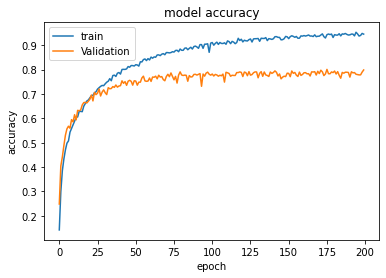

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl')

from sklearn.metrics import accuracy_score
y_pred=model.predict(test)
test_preds=( y_pred> 0.5).astype("int32")#Selecting a label only if it has >0.5 probability
accuracy_score(test_target, test_preds)

0.8024325126075349

In [ ]:
yhat=np.argmax(y_pred,axis=1)
y=np.argmax(test_target,axis=1)
accuracy_score(y,yhat)

0.8083654701868882

In [ ]:
#converting predicted labels to waypoins.
pred_df=pd.DataFrame(yhat,columns=['Label'])
label_df=pd.DataFrame(label,columns=['X_up_limit','Y_up_limit','Label'])
label_df.head()
pred_df2 = pd.merge(pred_df, label_df, on='Label', how='left')
pred_df2.head()

,Label,X_up_limit,Y_up_limit
0,78,214.213216,169.39878
1,78,214.213216,169.39878
2,78,214.213216,169.39878
3,78,214.213216,169.39878
4,78,214.213216,169.39878


In [ ]:
wp_pred=list()
#Adjust wp to centers
distx=(label[1][0]-label[0][0])/2
disty=(label[10][1]-label[0][1])/2 #for 10X10 grid
pred_df2['X_up_limit']=pred_df2['X_up_limit']-distx
pred_df2['Y_up_limit']=pred_df2['Y_up_limit']-disty
pred_df2.head()

,Label,X_up_limit,Y_up_limit
0,78,204.347734,163.499172
1,78,204.347734,163.499172
2,78,204.347734,163.499172
3,78,204.347734,163.499172
4,78,204.347734,163.499172


In [ ]:
#Now we will calculate exact error in predicted and actual location
#We will consider only those waypoints which were present in the original data
#to calculate error and we will reject interpolated values which were introduced by us 
import math
sum_of_error=0
sum_sq_error=0
count=0
test_predicted=pred_df2[['X_up_limit','Y_up_limit']].values
for i in range(len(test_seq_wp)):
  for j in range(len(test_seq_wp[i])):
    if(test_seq_wp[i][j][2]==1):
      sum_of_error+=math.sqrt(((test_predicted[i][0]-test_seq_wp[i][j][0])**2)+((test_predicted[i][1]-test_seq_wp[i][j][1])**2))
      sum_sq_error+=((test_predicted[i][0]-test_seq_wp[i][j][0])**2)+((test_predicted[i][1]-test_seq_wp[i][j][1])**2)
      count+=1


MAE=sum_of_error/count
RMSE=math.sqrt(sum_sq_error/count)
print('MAE value is:',round(MAE,2))  
print('RMSE value is:',round(RMSE,2)) 

MAE value is: 17.29
RMSE value is: 27.83
